In [2]:
import numpy as np
import pandas as pd
from sklearn import tree
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

In [3]:
cols = ['Clump_thickness' , 'Uniformity_cell_size', 'Uniformity_cell_shape',
            'Marginal_Adhesion', 'Single_Epithelial_sz', 'Bare_Nuclei',
            'Bland_Chromatin', 'Normal_Nucleoli', 'Mitoses', 'Class']
df = pd.read_csv(r'E:\Courses\Sem3\Machine Learning\Assignment2\hw2_question1.csv', names = cols)
df.head(10)

,Clump_thickness,Uniformity_cell_size,Uniformity_cell_shape,Marginal_Adhesion,Single_Epithelial_sz,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses,Class
0,5,1,1,1,2,1,3,1,1,2
1,5,4,4,5,7,10,3,2,1,2
2,3,1,1,1,2,2,3,1,1,2
3,6,8,8,1,3,4,3,7,1,2
4,4,1,1,3,2,1,3,1,1,2
5,8,10,10,8,7,10,9,7,1,4
6,1,1,1,1,2,10,3,1,1,2
7,2,1,2,1,2,1,3,1,1,2
8,2,1,1,1,2,1,1,1,5,2
9,4,2,1,1,2,1,2,1,1,2


In [4]:
count = df['Class'].value_counts()
print('No of Benign Tumors:', count[2])
print('No of Malignant Tumors:', count[4])

No of Benign Tumors: 444
No of Malignant Tumors: 239


In [5]:
#Ratio of Class Values
def ratio(my_df):
    count = my_df['Class'].value_counts()
    return count[2]/count[4]

In [6]:
#Building the Train and Test Sets with Equal Representation
train_factor = 0.67
df = df.sort_values(['Class'])
split1 = (int) (count[2] * train_factor)
split2 = (int) (count[4] * train_factor)

df_train = pd.concat([df.iloc[0:split1,:],df.iloc[count[2]:(count[2]+split2),:]], axis=0)
#print(df_train.shape)
print("The Ratio in Training Set: ", ratio(df_train))

df_test = pd.concat([df.iloc[split1:count[2],:],df.iloc[(count[2]+split2):,:]], axis=0)
#print(df_test.shape)
print("The Ratio in Testing Set: ", ratio(df_test))

The Ratio in Training Set:  1.85625
The Ratio in Testing Set:  1.860759493670886


In [7]:
#Tree Implementation
#Splitting Dataset based on an Attribute and its Value
def test_split(col_idx, threshold, dataset):
    left_group, right_group = list(), list()
    for row in dataset:
        if row[col_idx] < threshold:
            # Left Group Lesser than Threshold 
            left_group.append(row)
        else:
            # Right Group Greater than or Equal to Threshold
            right_group.append(row)
    return left_group, right_group

#Gini Index Calculation
def get_gini_index(groups, classes):
    n_instances = float(sum([len(group) for group in groups]))
    gini = 0.0
    for group in groups:
        size = float(len(group))
        if size == 0:
            continue
        score = 0.0
        for class_val in classes:
            p = [row[-1] for row in group].count(class_val) / size
            score += p * p
        gini += (1.0 - score) * (size / n_instances)
    return gini

#Information Gain Calculation
def get_info_gain(groups, classes):
    n_instances = float(sum([len(group) for group in groups]))
    info_gain = 0.0
    for class_val in classes:
        total = 0
        this_class_count = 0
        for group in groups:
            total += len(group)
            this_class_count += [row[-1] for row in group].count(class_val)
        p = this_class_count / total
        if p != 1:
            info_gain += (-1 * p * math.log(1-p,2))

    for group in groups:
        size = float(len(group))
        if size == 0:
            continue
        child_entropy = 0.0
        for class_val in classes:
            p = [row[-1] for row in group].count(class_val) / size
            if p != 1:
                child_entropy += (-1 * p * math.log(1-p,2))
        info_gain -= (child_entropy) * (size / n_instances)
    return info_gain

#Select Best Split Point
def get_split(dataset, useGini = True):
    class_values = list(set(row[-1] for row in dataset))
    b_score = 999
    b_info_gain = -1
    for index in range(len(dataset[0])-1):
        for row in dataset:
            groups = test_split(index, row[index], dataset)
            if useGini == True:
                gini = get_gini_index(groups, class_values)
                if gini < b_score:
                    b_index, b_value, b_score, b_groups = index, row[index], gini, groups
            else:
                info_gain = get_info_gain(groups, class_values)
                if info_gain > b_info_gain:
                    b_index, b_value, b_info_gain, b_groups = index, row[index], info_gain, groups
    return {'index':b_index, 'value':b_value, 'groups':b_groups}

#Creating a Terminal Node
def to_terminal(group):
    outcomes = [row[-1] for row in group]
    return max(set(outcomes), key=outcomes.count)

#Creating Child Splits at a Node or to Terminate
def split(node, useGini, node_queue):
    left, right = node['groups']
    del(node['groups'])
    if not left or not right :
        node['left'] = node['right'] = to_terminal(left + right)
        return False

    node['left'] = get_split(left)
    node_queue.append(node['left'])
    node['right'] = get_split(right)
    node_queue.append(node['right'])
    return True
    
        
#Building Decision Tree
def build_tree(train, max_nodes, useGini):
    node_queue = []
    root = get_split(train, useGini)
    num_nodes = 2
    node_queue.append(root)
    while (len(node_queue) != 0) and (num_nodes < max_nodes):
        this_node = node_queue.pop(0)
        new_node = split(this_node, useGini, node_queue)
        if new_node == True:
            num_nodes += 1
            
    
    if len(node_queue) != 0:
        while len(node_queue) != 0:
            this_node = node_queue.pop(0)
            left, right = this_node['groups']
            del(this_node['groups'])
            this_node['left'] = this_node['right'] = to_terminal(left + right)
        return [root, False]
    else:
        return [root, True]

#Make a Prediction with a Decision Tree
def predict(node, row):
    if row[node['index']] < node['value']:
        if isinstance(node['left'], dict):
            return predict(node['left'], row)
        else:
            return node['left']
    else:
        if isinstance(node['right'], dict):
            return predict(node['right'], row)
        else:
            return node['right']
        
#Calculate Accuracy%
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0
 
#Classification and Regression Tree Algorithm
def decision_tree(train, test, num_nodes, useGini = True):
    [tree, finish] = build_tree(train, num_nodes, useGini)
    train_predictions = list()
    for row in train:
        prediction = predict(tree, row)
        train_predictions.append(prediction)
    
    test_predictions = list()
    for row in test:
        prediction = predict(tree, row)
        test_predictions.append(prediction)
    return [accuracy_metric(train[:,-1], train_predictions) , accuracy_metric(test[:,-1], test_predictions), finish]

In [8]:
# Gini-Index and Entropy based Tree Building
# The Maximum No of Nodes in Tree
max_nodes_entropy = 2
max_nodes_gini = 2

entropy_train_acc = []
entropy_test_acc = []
gini_train_acc = []
gini_test_acc = []

while True:
    [train_accuracy, test_accuracy, finish] = decision_tree(df_train.values, df_test.values, max_nodes_gini)
    gini_train_acc.append(train_accuracy)
    gini_test_acc.append(test_accuracy)
    if finish == True:
        break
    max_nodes_gini += 1

while True:
    [train_accuracy, test_accuracy, finish] = decision_tree(df_train.values, df_test.values, max_nodes_entropy, useGini = False)
    entropy_train_acc.append(train_accuracy)
    entropy_test_acc.append(test_accuracy)
    if finish == True:
        break
    max_nodes_entropy += 1

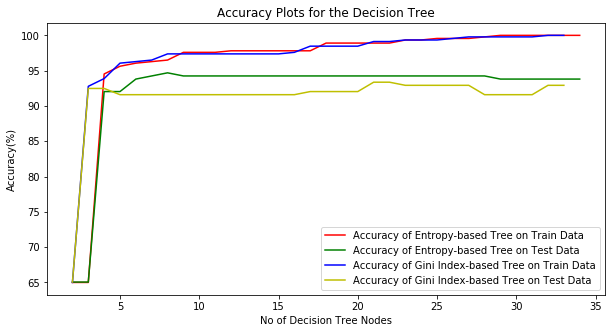

In [9]:
plt.figure(figsize=(10,5))
plt.plot(range(2,max_nodes_entropy+1), entropy_train_acc, 'r-', label = "Accuracy of Entropy-based Tree on Train Data")
plt.plot(range(2,max_nodes_entropy+1), entropy_test_acc, 'g-', label = "Accuracy of Entropy-based Tree on Test Data ")
plt.plot(range(2,max_nodes_gini+1), gini_train_acc, 'b-', label = "Accuracy of Gini Index-based Tree on Train Data")
plt.plot(range(2,max_nodes_gini+1), gini_test_acc, 'y-', label = "Accuracy of Gini Index-based Tree on Test Data")
plt.legend(loc='best')
plt.title("Accuracy Plots for the Decision Tree")
plt.xlabel("No of Decision Tree Nodes")
plt.ylabel("Accuracy(%)")
plt.show()

In [37]:
# K-Fold Primary Stratifified
kfold = StratifiedKFold(n_splits = 10)
test_acc_list = []
feature_imp_list = []

for train_index, test_index in kfold.split(df.iloc[:,:-1], df.iloc[:,-1]):
    df_train, df_test = df.iloc[train_index], df.iloc[test_index]
    #To Select the Best Model on the Secondary K-Fold Data
    best_model = RandomForestClassifier(n_estimators=10, max_depth=2, random_state=0)
    best_acc_validation = 0
    for tree_depth in range(2,7):
        for number_of_trees in range(10,20):
            current_model = RandomForestClassifier(n_estimators=number_of_trees, max_depth=tree_depth, random_state=0)
            total_score = 0 
            for sec_train_index, sec_test_index in kfold.split(df_train.iloc[:,:-1], df_train.iloc[:,-1]):
                df_train_inner, df_validate = df_train.iloc[sec_train_index], df_train.iloc[sec_test_index]
                current_model.fit(df_train_inner.iloc[:,:-1], df_train_inner.iloc[:,-1])
                total_score += current_model.score(df_validate.iloc[:,:-1], df_validate.iloc[:,-1])
            if (total_score > best_acc_validation) :
                best_model = current_model
                best_acc_validation = total_score
    
    test_acc_list.append(best_model.score(df_test.iloc[:,:-1], df_test.iloc[:,-1]))
    feature_imp_list.append(best_model.feature_importances_)        

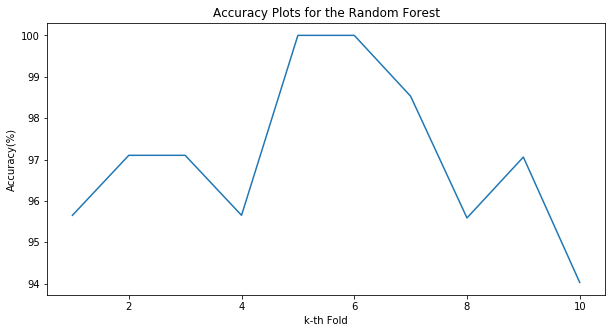

In [38]:
plt.figure(figsize=(10,5))
plt.plot(range(1, 11), [x*100 for x in test_acc_list])
plt.title("Accuracy Plots for the Random Forest")
plt.xlabel("k-th Fold")
plt.ylabel("Accuracy(%)")
plt.show()

In [44]:
score = np.zeros((df.shape[1] - 1, 2))
for i in range(df.shape[1] - 1):
    score[i,0] = i
for arr in feature_imp_list:
    for i in range(df.shape[1] - 1):
        score[i,1] += arr[i]
rank = score[score[:,1].argsort()[::-1][:df.shape[1] - 1]]
final_rank = rank[:,0].astype(int)
#print(final_rank)
print("Feature Importance Rank List (From High to Low): ")
for i in range(df.shape[1] - 1):
    print('Rank: ', i + 1, '-- Feature: ', cols[final_rank[i]])        

Feature Importance Rank List (From High to Low): 
Rank:  1 -- Feature:  Uniformity_cell_size
Rank:  2 -- Feature:  Bland_Chromatin
Rank:  3 -- Feature:  Single_Epithelial_sz
Rank:  4 -- Feature:  Uniformity_cell_shape
Rank:  5 -- Feature:  Normal_Nucleoli
Rank:  6 -- Feature:  Bare_Nuclei
Rank:  7 -- Feature:  Clump_thickness
Rank:  8 -- Feature:  Marginal_Adhesion
Rank:  9 -- Feature:  Mitoses
